In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\")

In [2]:
import data.load_data as dat
from model import SIRModelSolver
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import re

In [3]:
## Import the data
df = dat.load_csse_data()

C:\Users\never\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


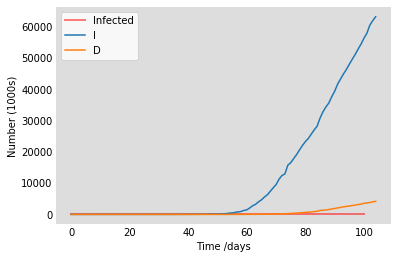

In [9]:
## Total population
N = 37_262_000
## Initial number of infected
I0 = 1
## Initial number of recoveries
R0 = 0
## Initial number of susceptibles people
S0 = N - I0 - R0
## Number of people infected by one diseased person
β = 2
## Recovery rate
γ = 2
## A grid of time points (in days)
t = np.linspace(0, 100)
## Initial conditions vector
y0 = S0, I0, R0

sir = SIRModelSolver.SIRModelSolver(β, γ)
S, I, R = odeint(sir._deriv, y0, t, args=(N, β, γ)).T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
    
df[['I','D']].plot(ax=ax)

plt.show()

In [22]:
##On va désormais tenter de curve fit sur nos données au lieu de définir les paramètres
f = lambda t, β, γ : (odeint(deriv, y0, t, args=(N, β, γ)).T)[1]
params, covariance = scipy.optimize.curve_fit(f, range(df.shape[0]), df['I'])
print("Params [β, γ] = [%s], Barres d'erreurs = [%s]" % (params, covariance))

Params [β, γ] = [[2.25944612 2.13510242]], Barres d'erreurs = [[[0.00038001 0.00037602]
 [0.00037602 0.00037218]]]


C:\Users\never\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys
C:\Users\never\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\never\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':


## La partie qui suit n'est pas totallement fonctionnelle

In [8]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
    f, ax = plt.subplots(1,1,figsize=(10,4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Deaths')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    if L is not None:
        plt.title("Lockdown after {} days".format(L))
    plt.show();

    if R0 is not None or CFR is not None:
        f = plt.figure(figsize=(12,4))

    if R0 is not None:
        # sp1
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0')
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    if Alpha is not None:
        # sp2
        ax2 = f.add_subplot(122)
        ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

    plt.show();

In [14]:
from model import SEIRDModelSolver

## Population totale
N = 1_000_000
## Durée de l'infection
D = 14.0
## Nombre de personnes qui recover chaque jour
gamma = 1.0/D
## Temps d'incubation du virus
delta = 1./14.
## Nombre de personnes total qu'une personne infecte
R_0 = 3.
##
beta = R_0 * gamma
## Taux de mortalité
alpha = 0.02
## Nombre de jours avant de mourir d'une infection
rho = 1./7.
## Susceptible / Exposés / Infectés / Recoveré
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0
t = np.linspace(0,99,100)
## Conditions initiales
y0 = S0, E0, I0, R0, D0

seird = SEIRDModelSolver.SEIRDModelSolver(alpha, beta, delta, gamma, rho)

ret = seird._deriv(y0, t, alpha, beta, delta, gamma, rho)

plotseird(t, S, E, I, R, D)

IndexError: list assignment index out of range